In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from keras.callbacks import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.pyplot as plt
import os

np.random.seed(2018)


/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Read feature：

In [3]:
h5_file = "feature_Xception.h5"

with h5py.File(h5_file, 'r') as h:
    X_train = np.array(h['train'])
    X_val = np.array(h['val'])
    X_test = np.array(h['test'])
    y_train = np.array(h['train_label'])
    y_val = np.array(h['val_label'])

X_train, y_train = shuffle(X_train, y_train)


In [4]:
print(X_train.shape)

(19916, 2048)


### Model adjustment:

In [15]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.7)(input_tensor)
x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
model = Model(input_tensor, x)

opt = optimizers.Adam(lr=1e-3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
             ModelCheckpoint(filepath='Xception_top_weights.h5', monitor='val_loss', verbose=0, save_best_only=True)]
history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 19916 samples, validate on 4979 samples
Epoch 1/30
19916/19916 [==============================] - 1s 59us/step - loss: 0.1455 - acc: 0.9717 - val_loss: 0.0436 - val_acc: 0.9940
Epoch 2/30
19916/19916 [==============================] - 1s 43us/step - loss: 0.0416 - acc: 0.9927 - val_loss: 0.0274 - val_acc: 0.9940
Epoch 3/30
19916/19916 [==============================] - 1s 48us/step - loss: 0.0309 - acc: 0.9932 - val_loss: 0.0220 - val_acc: 0.9946
Epoch 4/30
19916/19916 [==============================] - 1s 49us/step - loss: 0.0263 - acc: 0.9936 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 5/30
19916/19916 [==============================] - 1s 46us/step - loss: 0.0229 - acc: 0.9947 - val_loss: 0.0180 - val_acc: 0.9952
Epoch 6/30
19916/19916 [==============================] - 1s 47us/step - loss: 0.0203 - acc: 0.9950 - val_loss: 0.0175 - val_acc: 0.9948
Epoch 7/30
19916/19916 [==============================] - 1s 42us/step - loss: 0.0209 - acc: 0.9946 - val_loss: 0.0163 - val_acc:

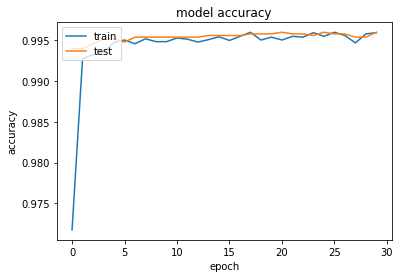

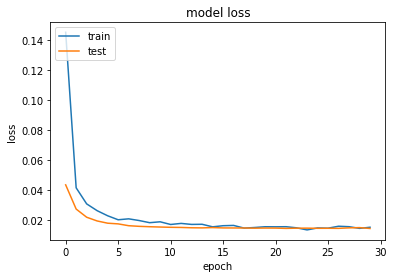

In [17]:
plot_history(history)

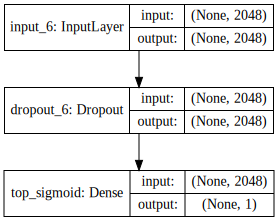

In [18]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train in total training data:

In [23]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.7)(input_tensor)
x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
model = Model(input_tensor, x)

opt = optimizers.Adam(lr=1e-3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
X_val, y_val = shuffle(X_val, y_val)
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), batch_size=128, epochs=30, validation_split=0)

Epoch 1/30
24895/24895 [==============================] - 1s 43us/step - loss: 0.1325 - acc: 0.9710
Epoch 2/30
24895/24895 [==============================] - 1s 35us/step - loss: 0.0367 - acc: 0.9926
Epoch 3/30
24895/24895 [==============================] - 1s 32us/step - loss: 0.0284 - acc: 0.9931
Epoch 4/30
24895/24895 [==============================] - 1s 32us/step - loss: 0.0242 - acc: 0.9942
Epoch 5/30
24895/24895 [==============================] - 1s 32us/step - loss: 0.0225 - acc: 0.9941
Epoch 6/30
24895/24895 [==============================] - 1s 27us/step - loss: 0.0206 - acc: 0.9942
Epoch 7/30
24895/24895 [==============================] - 1s 25us/step - loss: 0.0198 - acc: 0.9943
Epoch 8/30
24895/24895 [==============================] - 1s 28us/step - loss: 0.0191 - acc: 0.9947
Epoch 9/30
24895/24895 [==============================] - 1s 35us/step - loss: 0.0168 - acc: 0.9953
Epoch 10/30
24895/24895 [==============================] - 1s 33us/step - loss: 0.0196 - acc: 0.9941

### Predict:

In [25]:
y_pred = model.predict(X_test, verbose=1)


12500/12500 [==============================] - 1s 59us/step


In [28]:
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

In [29]:
df = pd.read_csv("sampleSubmission.csv")

image_size = (299, 299)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", image_size, shuffle=False, 
                                         batch_size=64, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind(os.sep)+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.9995
1,2,0.9995
2,3,0.9995
3,4,0.9995
4,5,0.0005
5,6,0.0005
6,7,0.0005
7,8,0.0005
8,9,0.0005
9,10,0.0005
